In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import dice_coef, ss_metric, compute_metric
import nibabel as nib
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
max_epochs = 30
BATCH_SIZE = 24
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'DeepSupervisedAttentionUNet02' #save version 
dropout=0.3 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/'
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack03/"

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

def data_aug(imgs, seed=8888):
    x = tf.image.random_flip_up_down(imgs,seed)
    x = tf.image.random_flip_left_right(x,seed)
    return x

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool, attention_block
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply, GaussianNoise

def AttUnet_model(input_layer, attention_mode='grid'):
    gauss1 = GaussianNoise(0.01)(input_layer)
    #downsampling path
    conv1 = conv_block(gauss1, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn, dropout_rate = dropout)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn, dropout_rate = dropout)
    
    #upsampling path
    att01 = attention_block(conv4, conv5, 512)
    up1 = up(conv5,filters=512, merge=att01, kernel_initializer=hn)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att02 = attention_block(conv3, conv6, 256)
    else:
        att02 = attention_block(conv3, conv4, 256)
    up2 = up(conv6, filters=256, merge=att02, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    #injection block 1
    seg01 = Conv2D(4,(1,1),padding='same')(conv7)
    up_seg01 = UpSampling2D()(seg01)
    
    if attention_mode=='grid':
        att03 = attention_block(conv2, conv7, 128)
    else:
        att03 = attention_block(conv2, conv3, 128)
    up3 = up(conv7, filters=128, merge=att03, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    #injection block 2
    seg02 = Conv2D(4,(1,1),padding='same')(conv8)
    add_21 = Add()([seg02, up_seg01])
    up_seg02 = UpSampling2D()(add_21)
    
    if attention_mode=='grid':
        att04 = attention_block(conv1, conv8, 64)
    else:
        att04 = attention_block(conv1, conv2, 64)
    up4 = up(conv8, filters=64, merge=att04, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    #injection block 3
    seg03 = Conv2D(4,(1,1),padding='same')(conv9)
    add_32 = Add()([seg03, up_seg02])
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(add_32)
    
    return output_layer

In [5]:
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, AttUnet_model(input_layer))

In [6]:
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image)
        loss = custom_loss(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients

---


Epochs  1



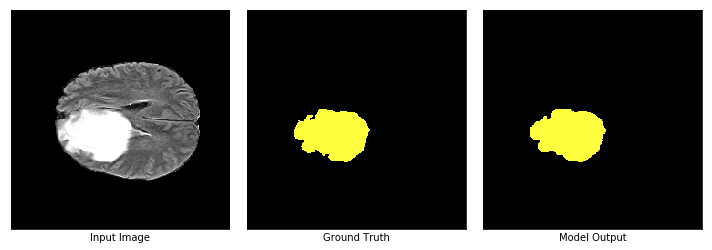

Steps: 2000, Loss:0.3848484456539154
Accurary: 0.9976388812065125
Dice coefficient: [1.0, 1.0, 0.9802727]
Sensitivity: [1.0, 1.0, 0.9868574766738976]
Specificity: [1.0, 1.0, 0.9983202894273626]
Gradient min:-0.07565556466579437, max:0.09510085731744766
Compute time per epochs: 0.59 mins

Epochs  2



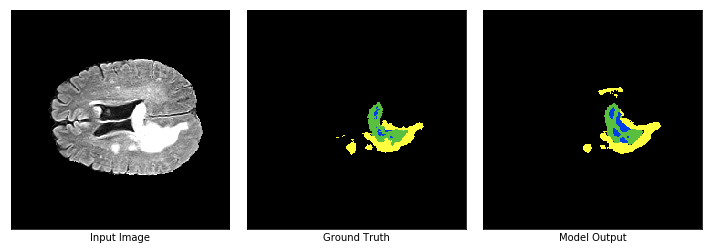

Steps: 2000, Loss:0.36076000332832336
Accurary: 0.9868402481079102
Dice coefficient: [0.87082404, 0.8814286, 0.862897]
Sensitivity: [0.9490291268321708, 0.8440492497394083, 0.9366591931801614]
Specificity: [0.9966535155705486, 0.9990856178235795, 0.9925111079273844]
Gradient min:-0.0877402126789093, max:0.0880039855837822
Compute time per epochs: 0.58 mins

Epochs  3



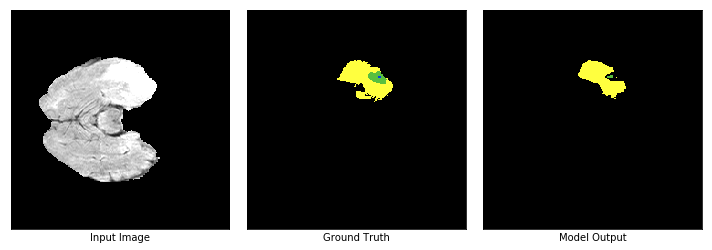

Steps: 2000, Loss:0.46259286999702454
Accurary: 0.9906250238418579
Dice coefficient: [0.14492753, 0.15151516, 0.8142747]
Sensitivity: [0.07812504801432041, 0.08196726328047742, 0.6930111058588432]
Specificity: [1.0, 1.0, 0.9997503076566819]
Gradient min:-0.37184247374534607, max:0.47599706053733826
Compute time per epochs: 0.59 mins

Epochs  4



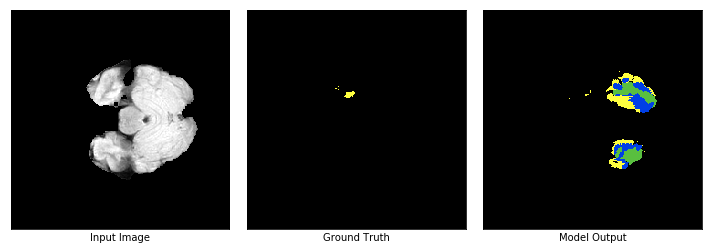

Steps: 2000, Loss:0.9820089340209961
Accurary: 0.9578298330307007
Dice coefficient: [0.0, 0.0, 0.0057306592]
Sensitivity: [1.0, 1.0, 0.10769244497039307]
Specificity: [0.9724826388936663, 0.9868750000022787, 0.9587903015627374]
Gradient min:-0.17533031105995178, max:0.14699609577655792
Compute time per epochs: 0.58 mins

Epochs  5



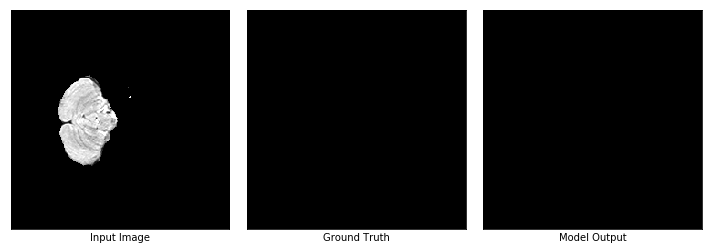

Steps: 2000, Loss:0.2940883934497833
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.2530762553215027, max:0.27344968914985657

-----------<Summary for Epoch:5>------------
Mean Accuracy: 0.9943005442619324
Mean Dice coefficient: [0.88157608 0.8855331  0.82757411]
Mean Sensitivity: [0.91056955 0.92500811 0.86632507]
Mean Specificity: [0.9993617  0.99953424 0.99878458]
------------------------------------------------

Compute time per epochs: 2.01 mins

Epochs  6



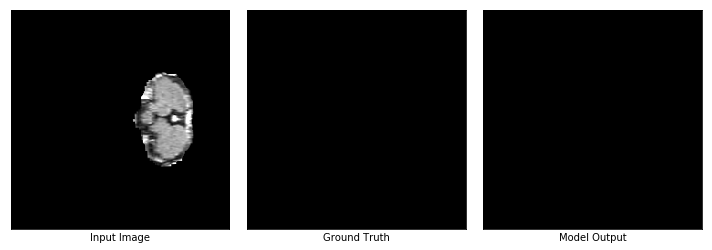

Steps: 2000, Loss:0.23470821976661682
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.04786241054534912, max:0.06034312769770622
Compute time per epochs: 0.58 mins

Epochs  7



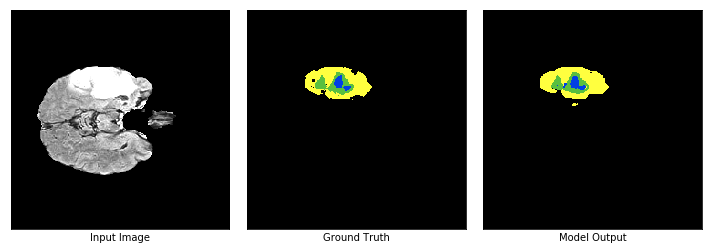

Steps: 2000, Loss:0.21778050065040588
Accurary: 0.9948437213897705
Dice coefficient: [0.93461204, 0.8848921, 0.9512894]
Sensitivity: [0.933797910561012, 0.8561484952169722, 0.9540229887459614]
Specificity: [0.9993511731492036, 0.9994052720881238, 0.9982221743349815]
Gradient min:-0.049618739634752274, max:0.05620848760008812
Compute time per epochs: 0.58 mins

Epochs  8



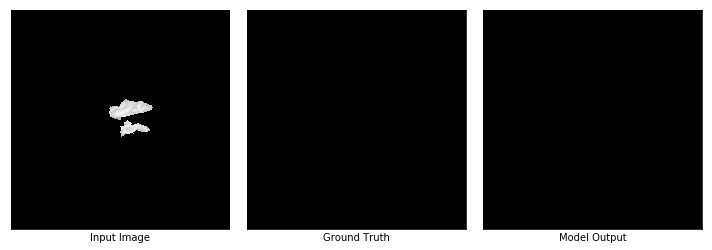

Steps: 2000, Loss:0.1587895005941391
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02650495618581772, max:0.022668369114398956
Compute time per epochs: 0.58 mins

Epochs  9



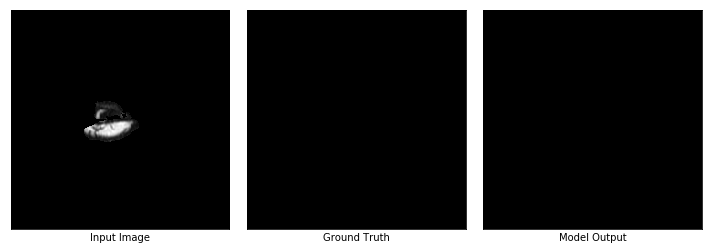

Steps: 2000, Loss:0.15841646492481232
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06510692834854126, max:0.07697492092847824
Compute time per epochs: 0.58 mins

Epochs 10



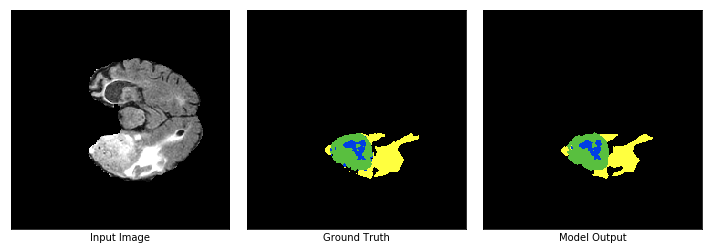

Steps: 2000, Loss:0.2595531642436981
Accurary: 0.9934548735618591
Dice coefficient: [0.97119623, 0.9533417, 0.94834346]
Sensitivity: [0.9656334234121737, 0.9553496212691691, 0.9185645275411852]
Specificity: [0.999394112196273, 0.9989718681865932, 0.999012833168986]
Gradient min:-0.01694478839635849, max:0.027461620047688484

-----------<Summary for Epoch:10>------------
Mean Accuracy: 0.9951475262641907
Mean Dice coefficient: [0.8927816  0.89938487 0.84878853]
Mean Sensitivity: [0.91429992 0.93250436 0.87361501]
Mean Specificity: [0.99949882 0.99960453 0.99897904]
------------------------------------------------

Compute time per epochs: 2.00 mins

Epochs 11



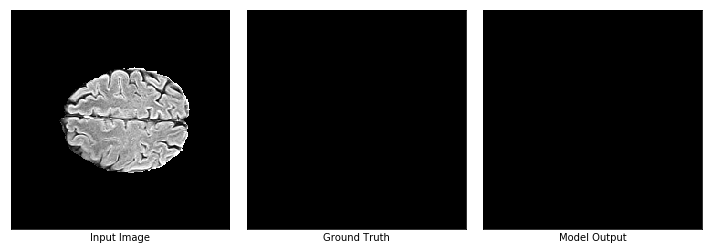

Steps: 2000, Loss:0.16839678585529327
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.025060081854462624, max:0.02745361439883709
Compute time per epochs: 0.58 mins

Epochs 12



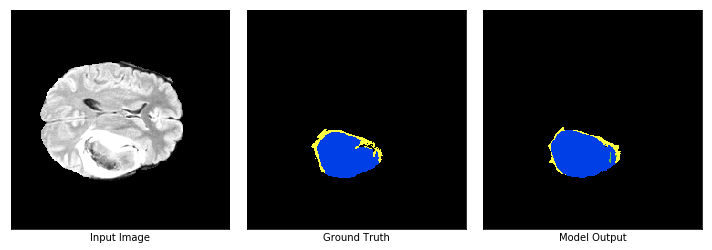

Steps: 2000, Loss:0.26687681674957275
Accurary: 0.9906076192855835
Dice coefficient: [0.9283356, 0.0, 0.96071905]
Sensitivity: [0.9896480331691593, 1.0, 0.9890335846846005]
Specificity: [0.9937664220361029, 0.9996701388889462, 0.9962693390884991]
Gradient min:-0.09895745664834976, max:0.09157165884971619
Compute time per epochs: 0.58 mins

Epochs 13



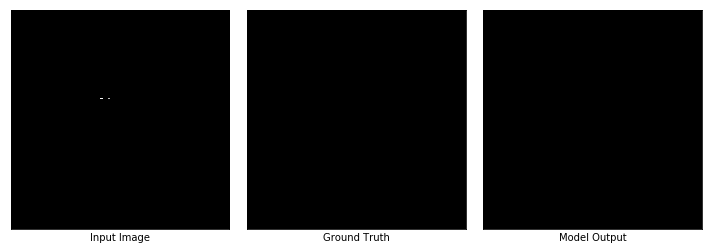

Steps: 2000, Loss:0.10903564840555191
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.18836842477321625, max:0.12916342914104462
Compute time per epochs: 0.58 mins

Epochs 14



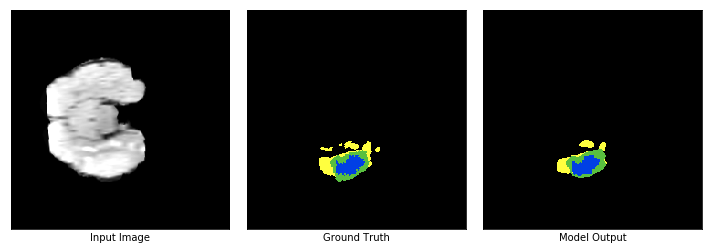

Steps: 2000, Loss:0.16007961332798004
Accurary: 0.9917882084846497
Dice coefficient: [0.9298334, 0.81000924, 0.88576216]
Sensitivity: [0.915506959090388, 0.7989031115374202, 0.8125384154115648]
Specificity: [0.9990458352477214, 0.9983348816016099, 0.9993568327587664]
Gradient min:-0.02608112432062626, max:0.020899232476949692
Compute time per epochs: 0.61 mins

Epochs 15



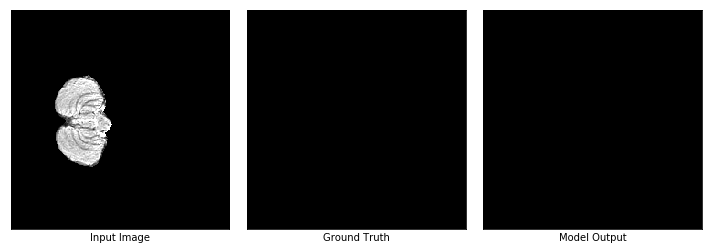

Steps: 2000, Loss:0.14536835253238678
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.015002654865384102, max:0.03577437251806259

-----------<Summary for Epoch:15>------------
Mean Accuracy: 0.9955677390098572
Mean Dice coefficient: [0.9018589  0.90924118 0.85713956]
Mean Sensitivity: [0.92086619 0.93582178 0.87983197]
Mean Specificity: [0.99953348 0.99964931 0.99906352]
------------------------------------------------

Compute time per epochs: 2.01 mins

Epochs 16



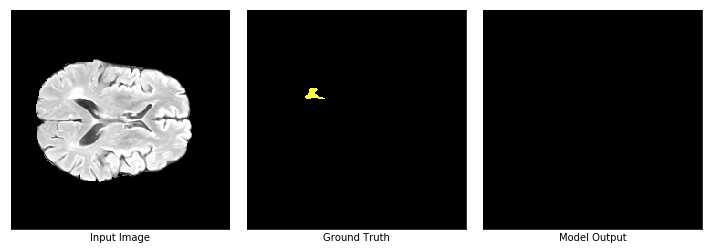

Steps: 2000, Loss:0.1230274885892868
Accurary: 0.9977777600288391
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 7.812499389648486e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.014035968109965324, max:0.014758927747607231
Compute time per epochs: 0.56 mins

Epochs 17



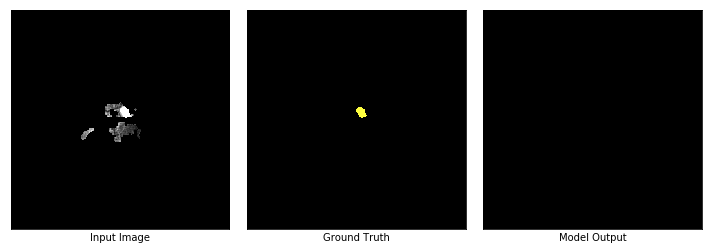

Steps: 2000, Loss:0.12405149638652802
Accurary: 0.9984895586967468
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 1.149425155238488e-07]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.04296676814556122, max:0.06502540409564972
Compute time per epochs: 0.58 mins

Epochs 18



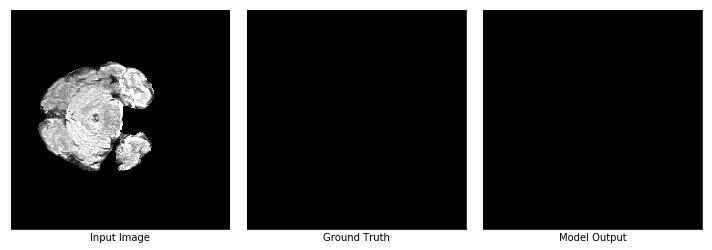

Steps: 2000, Loss:0.0966261774301529
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.021511467173695564, max:0.01350835058838129
Compute time per epochs: 0.58 mins

Epochs 19



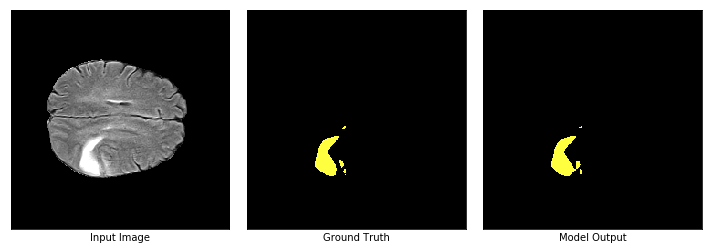

Steps: 2000, Loss:0.20928926765918732
Accurary: 0.9987499713897705
Dice coefficient: [1.0, 1.0, 0.9505494]
Sensitivity: [1.0, 1.0, 0.9651324969995467]
Specificity: [1.0, 1.0, 0.9991737425945935]
Gradient min:-0.06514089554548264, max:0.060855939984321594
Compute time per epochs: 0.58 mins

Epochs 20



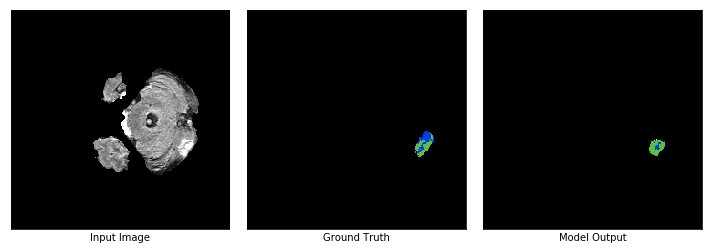

Steps: 2000, Loss:0.277597039937973
Accurary: 0.9959548711776733
Dice coefficient: [0.65377855, 0.6819484, 0.6620209]
Sensitivity: [0.5284091043065596, 0.7041420293407084, 0.5397727403473653]
Specificity: [0.9994584963667799, 0.9989378558620017, 0.9994410285076437]
Gradient min:-0.05150913819670677, max:0.037462908774614334

-----------<Summary for Epoch:20>------------
Mean Accuracy: 0.9958318471908569
Mean Dice coefficient: [0.90852871 0.91528428 0.868523  ]
Mean Sensitivity: [0.92194706 0.93887594 0.88445696]
Mean Specificity: [0.99959285 0.99967476 0.99914851]
------------------------------------------------

Compute time per epochs: 1.99 mins

Epochs 21



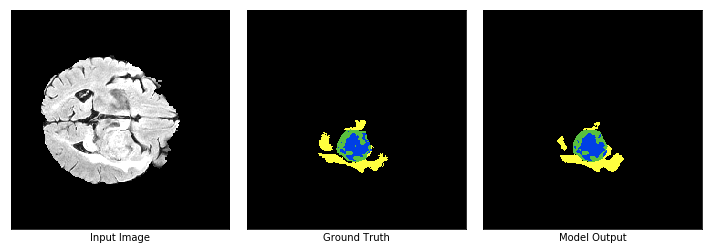

Steps: 2000, Loss:0.15104719996452332
Accurary: 0.9912673830986023
Dice coefficient: [0.9798465, 0.8940464, 0.8950219]
Sensitivity: [0.9845708776801265, 0.8877755533511913, 0.8780364378641881]
Specificity: [0.9995403355551261, 0.999141871420966, 0.997015676686859]
Gradient min:-0.026777708902955055, max:0.035129375755786896
Compute time per epochs: 0.57 mins

Epochs 22



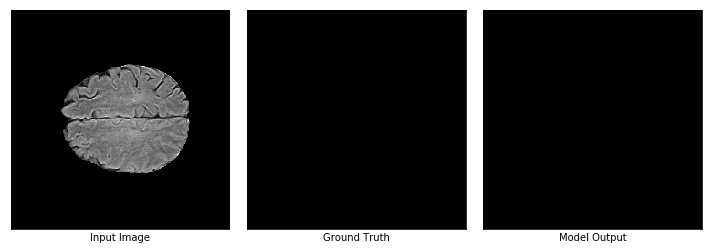

Steps: 2000, Loss:0.09680292755365372
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.017392689362168312, max:0.02074461802840233
Compute time per epochs: 0.58 mins

Epochs 23



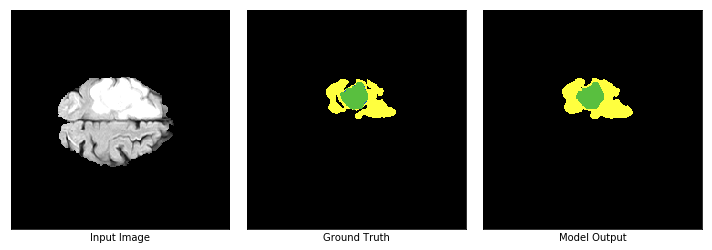

Steps: 2000, Loss:0.26166287064552307
Accurary: 0.9953472018241882
Dice coefficient: [0.9786223, 0.98083067, 0.94644856]
Sensitivity: [0.9716981136525454, 0.9824000002816, 0.9995267392355573]
Specificity: [0.9998420054771712, 0.9997718297499304, 0.9957107070132264]
Gradient min:-0.07000171393156052, max:0.07392826676368713
Compute time per epochs: 0.58 mins

Epochs 24



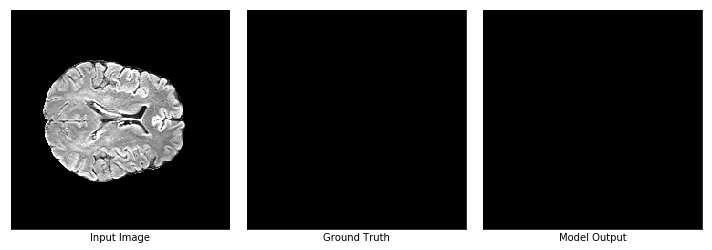

Steps: 2000, Loss:0.1906486451625824
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.012779196724295616, max:0.014989303424954414
Compute time per epochs: 0.60 mins

Epochs 25



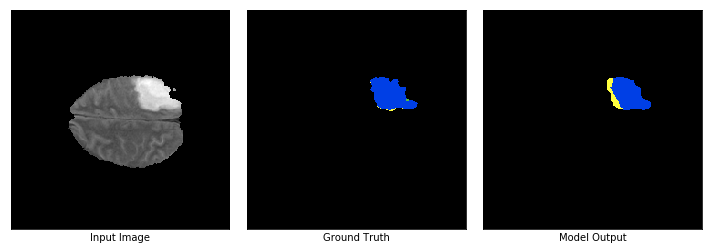

Steps: 2000, Loss:0.23489336669445038
Accurary: 0.9948958158493042
Dice coefficient: [0.87828803, 0.0, 0.9590164]
Sensitivity: [0.8106995900353943, 1.1111098765445817e-06, 0.9466019421795959]
Specificity: [0.9992373858296999, 1.0, 0.9993967780854097]
Gradient min:-0.11675283312797546, max:0.06985418498516083

-----------<Summary for Epoch:25>------------
Mean Accuracy: 0.9960291981697083
Mean Dice coefficient: [0.91169893 0.92009506 0.87031459]
Mean Sensitivity: [0.92597284 0.94053752 0.88635393]
Mean Specificity: [0.99958182 0.99969542 0.9991675 ]
------------------------------------------------

Compute time per epochs: 2.01 mins

Epochs 26



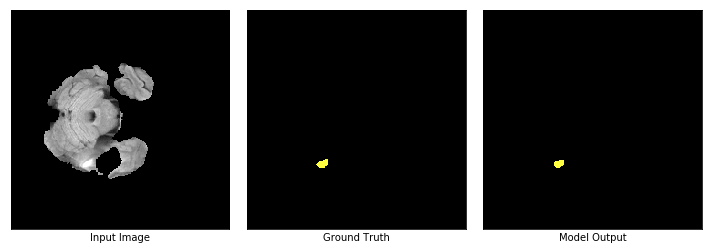

Steps: 2000, Loss:0.11824287474155426
Accurary: 0.99979168176651
Dice coefficient: [1.0, 1.0, 0.9285714]
Sensitivity: [1.0, 1.0, 0.8764045082691564]
Specificity: [1.0, 1.0, 0.999982612022051]
Gradient min:-0.04717624559998512, max:0.033230915665626526
Compute time per epochs: 0.59 mins

Epochs 27



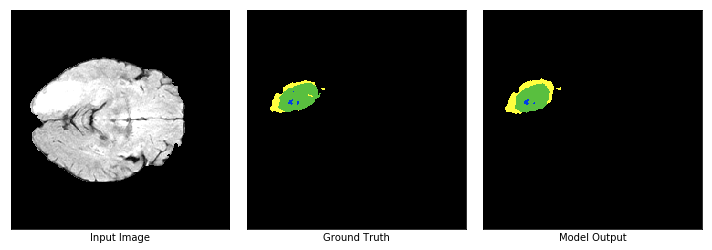

Steps: 2000, Loss:0.0830501988530159
Accurary: 0.9951909780502319
Dice coefficient: [0.91205895, 0.90535426, 0.9492754]
Sensitivity: [0.8591269855245338, 0.8523421603631145, 0.982008995637114]
Specificity: [0.9995582414476325, 0.9994701331732894, 0.9979383641989944]
Gradient min:-0.019220490008592606, max:0.010546916164457798
Compute time per epochs: 0.59 mins

Epochs 28



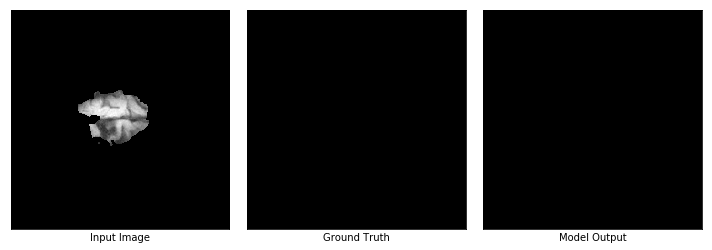

Steps: 2000, Loss:0.1763043850660324
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06046105548739433, max:0.055876441299915314
Compute time per epochs: 0.58 mins

Epochs 29



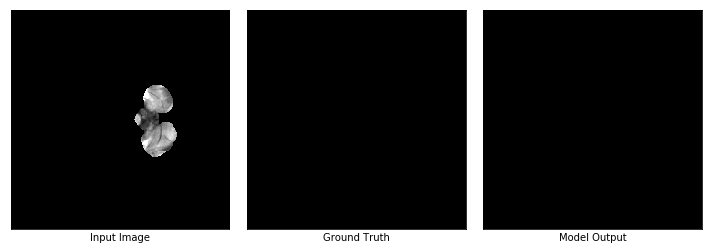

Steps: 2000, Loss:0.15553414821624756
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03613704442977905, max:0.056776415556669235
Compute time per epochs: 0.59 mins

Epochs 30



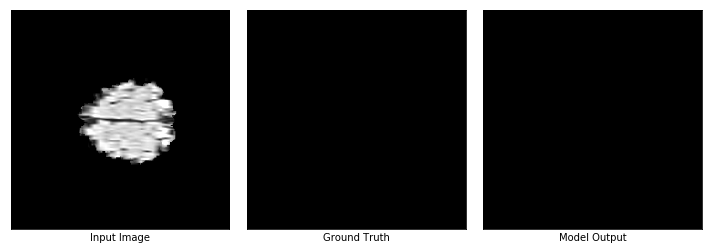

Steps: 2000, Loss:0.22277972102165222
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.10979820787906647, max:0.07970666885375977

-----------<Summary for Epoch:30>------------
Mean Accuracy: 0.9961896538734436
Mean Dice coefficient: [0.91614015 0.92467914 0.87700023]
Mean Sensitivity: [0.92837932 0.9431011  0.89111549]
Mean Specificity: [0.99959841 0.99970709 0.99921022]
------------------------------------------------

Compute time per epochs: 2.01 mins


In [7]:
epochs = 1
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    start = time.time()
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    ds = os.listdir(tfrecords_read_dir)
    #shuffle directory list of tfrecords
    shuffle = random.shuffle(ds)
    for tf_re in ds:
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            #data augmentation
            imgs = data_aug(imgs)
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        #'core','enhancing','complete'
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    elapsed_time =(time.time()-start)/60 #unit in mins
    print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
    epochs+=1 

---

# Save Weights

In [8]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [12]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def val_fn(image):
    model.trainable = False
    model_output = model(image)
    return model_output

In [13]:
ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/'
save_path = '/home/kevinteng/Desktop/ssd02/submission/'
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
#all brain affine are the same just pick one 
brain_affine = nib.load(actual_label).affine
steps = 1
acc_list = []
for train_or_val in sorted(os.listdir(ds)):
    save_dir = save_path + train_or_val+'_'+ver
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    merge01 = os.path.join(ds+train_or_val)
    for patient in sorted(os.listdir(merge01)):
        patient_id = patient.split('.')[0]
        merge02 = os.path.join(merge01,patient)
        imgs = np.load(merge02)
        image = imgs[:,:,:,:4]
        seg_output = 0 #flush RAM
        seg_output = np.zeros((240,240,155))
        for i in range(image.shape[0]):
            inp = tf.expand_dims(image[i],0)
            img_seg = val_fn(inp) #validation function 
            #map from sparse to label
            seg_output[:,:,i] = np.argmax(img_seg,-1) 
        #convert label from 4 to 3 and np array and cast as int
        seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
        prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
        prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

---

# Model Summary

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 240, 240, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 2368        gaussian_noise[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________